In [936]:
# Import required libaries 
import cv2 
import matplotlib.pyplot as plt 
import numpy as np 
import wget 
import os 
import pandas as pd
import numpy as np 

# Data Extraction

In [937]:
# Create dataframe from CSV 

# imagery_df = pd.read_csv('basic_good_image_set.csv')
# imagery_df = imagery_df.fillna('None')
# print(imagery_df.dtypes)
# print(imagery_df)

In [938]:
# Download files, should ONLY download if they are not already in to directory 
# Source of directory read technique: https://www.geeksforgeeks.org/python/python-list-files-in-a-directory/
# If we need to do any os related things you can grab os from: https://www.google.com/search?q=get+os+version+python&sca_esv=7a3339a54e4f1566&ei=Y0EWaevMCJaA0PEPhtjtmQw&ved=0ahUKEwiriuy5_e-QAxUWADQIHQZsO8MQ4dUDCBE&uact=5&oq=get+os+version+python&gs_lp=Egxnd3Mtd2l6LXNlcnAiFWdldCBvcyB2ZXJzaW9uIHB5dGhvbjIFEAAYgAQyBhAAGBYYHjIGEAAYFhgeMggQABiABBiiBDIFEAAY7wUyBRAAGO8FSLZXUMYPWKBWcAN4AZABAJgBjAGgAcYOqgEEMTkuMrgBA8gBAPgBAZgCGKACtA_CAgoQABiwAxjWBBhHwgILEAAYgAQYkQIYigXCAhAQABiABBixAxhDGIMBGIoFwgIWEC4YgAQYsQMY0QMYQxiDARjHARiKBcICEBAuGIAEGNEDGEMYxwEYigXCAgoQABiABBhDGIoFwgIKEC4YgAQYQxiKBcICCxAuGIAEGMcBGK8BwgIOEC4YgAQYsQMYgwEY1ALCAg4QABiABBixAxiDARiKBcICBRAuGIAEwgIIEC4YgAQYsQPCAgQQABgDwgIOEC4YgAQYsQMY0QMYxwHCAg0QABiABBixAxhDGIoFwgINEC4YgAQYsQMYQxiKBcICCxAuGIAEGLEDGNQCwgILEAAYgAQYsQMYgwHCAggQABiABBixA8ICCxAuGIAEGLEDGIMBwgIcEC4YgAQYsQMYQxiKBRiXBRjcBBjeBBjgBNgBAcICCxAAGIAEGIYDGIoFmAMAiAYBkAYIugYGCAEQARgUkgcEMTguNqAH6aABsgcEMTUuNrgHqQ_CBwcwLjExLjEzyAdS&sclient=gws-wiz-serp

# Select the path you want to evaluate, the only dataset currently is the basic known good image set 
# path = './city_images/raw/basic_good_image_set' 

# dir_list = os.listdir(path)
# imagery_df['date'] = imagery_df['date'].astype(str)
# for i in range(len(imagery_df)):
#     image_fn = imagery_df.iloc[i]['date']+'.jpg'
#     if not image_fn in dir_list:
#         print('Image not already in folder, downloading...')
#         image = wget.download(imagery_df['URL'][i],path+image_fn)
#     else:
#         print('Image already in image folder')

In [939]:
from dotenv import load_dotenv
load_dotenv() # Reads the .env file in the current directory
import os


ACCOUNT_NAME = os.environ.get("ACCOUNT_NAME")
ACCOUNT_KEY = os.environ.get("ACCOUNT_KEY")
storage_options = {
    "account_name": ACCOUNT_NAME,
    "account_key": ACCOUNT_KEY,
}
gold_prefix = "abfs://gold@ucalgarydatalake01.dfs.core.windows.net/calgary_cloud_quality_classification_2000_2025.parquet"

imagery_df = pd.read_parquet(
    gold_prefix,
    storage_options=storage_options,
    engine="fastparquet",
)

imagery_df['date'] = imagery_df['date'].astype(str)


In [940]:
# Only select images that do not have clouds and are in summer months, this will be more complicated if we don't manually label the cloudy data 
# print(f'Total length of precleaned dataset: {len(imagery_df)}') 
# cleaned_df = imagery_df.query("Month == 7 & Cloudiness.eq('None') & Greenness.eq('High')")
# print(f'Total length of cleaned dataset: {len(cleaned_df)}')

print(f'Total length of precleaned dataset: {len(imagery_df)}') 
cleaned_df = imagery_df.query("cloud_fraction < 0.007 ")
print(f'Total length of cleaned dataset: {len(cleaned_df)}')
manual_df = pd.DataFrame()
manual_df['year'] = range(2001,2025)
manual_df['Area Estimate'] = [585,591,621,623,659,682,675,702,712,744,752,742,744,771,779,768,802,786,797,804,836,830,864,854]
print(manual_df.head())

Total length of precleaned dataset: 2173
Total length of cleaned dataset: 34
   year  Area Estimate
0  2001            585
1  2002            591
2  2003            621
3  2004            623
4  2005            659


In [941]:
cleaned_df.dtypes

year                int64
date               object
rel_path           object
file_name          object
cloud_fraction    float64
quality_class       int64
dtype: object

In [942]:
from PIL import Image

def decode_fft_polar_uint8(encoded: dict) -> np.ndarray:
    """
    Invert the encode_fft_polar_uint8() representation back to a complex FFT array.
    """
    mag_q = encoded["mag_q"].astype(np.float32)
    phase_q = encoded["phase_q"].astype(np.float32)
    mag_max = float(encoded["mag_max"])
    shape = tuple(encoded["shape"].tolist())

    # Dequantize magnitude
    mag_norm = mag_q / 255.0
    mag_log = mag_norm * mag_max
    mag = np.expm1(mag_log)

    # Dequantize phase
    phase_norm = phase_q / 255.0
    phase = phase_norm * (2 * np.pi) - np.pi

    real = mag * np.cos(phase)
    imag = mag * np.sin(phase)
    fft_arr = (real + 1j * imag).astype(np.complex64)

    return fft_arr.reshape(shape)

def fft_rgb_to_image(fft_block: np.ndarray, width: int, height: int) -> Image.Image:
    fft_block = np.asarray(fft_block)
    if fft_block.ndim != 3 or fft_block.shape[2] != 3:
        raise ValueError(f"Expected fft_block of shape (K, K, 3), got {fft_block.shape}")

    K_h, K_w, C = fft_block.shape
    if K_h != K_w:
        raise ValueError(f"Expected square block, got {fft_block.shape}")
    if C != 3:
        raise ValueError("Expected 3 channels (RGB)")

    H, W = int(height), int(width)

    full_fft = np.zeros((H, W, 3), dtype=fft_block.dtype)

    cy, cx = H // 2, W // 2
    half = K_h // 2

    y0, y1 = cy - half, cy - half + K_h
    x0, x1 = cx - half, cx - half + K_h

    full_fft[y0:y1, x0:x1, :] = fft_block

    F_unshift = np.fft.ifftshift(full_fft, axes=(0, 1))
    img_complex = np.fft.ifft2(F_unshift, axes=(0, 1))  # (H, W, 3)
    img_real = np.real(img_complex)

    img_real = np.clip(img_real, 0, 255).astype(np.uint8)
    return Image.fromarray(img_real)

In [943]:
# import fsspec
# import json
# bronze_prefix = "abfs://raw@ucalgarydatalake01.dfs.core.windows.net/worldview_fft"

# i = 10
# year = cleaned_df.iloc[i]['year']
# date = cleaned_df.iloc[i]['date']
# #path = bronze_prefix + f"/year={year}/worldview_fft_{date.strip()}_MODIS_Terra_CorrectedReflectance_TrueColor,Coastlines_15m.npz"
# path = bronze_prefix + f"/year={year}/worldview_fft_{date}_MODIS_Terra_CorrectedReflectance_TrueColor,Coastlines_15m.npz"
# fs_,_,paths = fsspec.get_fs_token_paths(path, storage_options=storage_options)

# with fs_.open(paths[0], "rb") as f:
#     data = np.load(f, allow_pickle=True)
#     fft_arr = data["fft"]
#     meta = json.loads(data["meta"].item())

# recon_img = fft_rgb_to_image(fft_arr,275,275) #how to get the image from an fft.
# numpy_image = np.array(recon_img)
# opencv_image = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)

# red_channel = opencv_image[:, :, 2]
# blue_channel = opencv_image[:, :, 0]

# ret, red_bitmask = cv2.threshold(red_channel, 75, 150, cv2.THRESH_BINARY)
# ret, blue_bitmask = cv2.threshold(blue_channel, 75, 255, cv2.THRESH_BINARY)
# result_mask = cv2.bitwise_and(red_bitmask,blue_bitmask)
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 8))
# axes = axes.flatten()

# axes[0].imshow(red_bitmask)
# axes[0].set_title('Image 1')
# axes[0].axis('off')

# axes[1].imshow(blue_bitmask)
# axes[1].set_title('Image 3')
# axes[1].axis('off')

# axes[2].imshow(result_mask)
# axes[2].set_title('Image 3')
# axes[2].axis('off')


In [944]:
import fsspec
import json
bronze_prefix = "abfs://raw@ucalgarydatalake01.dfs.core.windows.net/worldview_fft"

for i in range(len(cleaned_df)):
    year = cleaned_df.iloc[i]['year']
    date = cleaned_df.iloc[i]['date']
    #path = bronze_prefix + f"/year={year}/worldview_fft_{date.strip()}_MODIS_Terra_CorrectedReflectance_TrueColor,Coastlines_15m.npz"
    path = bronze_prefix + f"/year={year}/worldview_fft_{date}_MODIS_Terra_CorrectedReflectance_TrueColor,Coastlines_15m.npz"
    fs_,_,paths = fsspec.get_fs_token_paths(path, storage_options=storage_options)

    with fs_.open(paths[0], "rb") as f:
        data = np.load(f, allow_pickle=True)
        fft_arr = data["fft"]
        meta = json.loads(data["meta"].item())

    recon_img = fft_rgb_to_image(fft_arr,275,275) #how to get the image from an fft.
    numpy_image = np.array(recon_img)
    opencv_image = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite('./city_images/cleaned/basic_good_image_set/'+date+'.jpg',opencv_image)


# Image Cleaning

In [945]:
# for im_fn in cleaned_df['date']:
#     image = cv2.imread('./city_images/raw/basic_good_image_set/'+im_fn+'.jpg')
#     cv2.imwrite('./city_images/cleaned/basic_good_image_set/'+im_fn+'.jpg',image)

# Image Processing

In [946]:
PROCESSING_METHOD = True

if PROCESSING_METHOD:
    # Improved image processing with boundaries to exclude surrounding towns
    # Also tracks urban growth over time - city only grows, never shrinks

    # HSV thresholds for green vegetation
    lower_green = np.array([40, 40, 0]) 
    upper_green = np.array([85, 255, 255]) 

    lower_grey = 0  
    upper_grey = 255

    # Define outer boundary to exclude Airdrie, Okotoks, etc
    outer_boundary = [
        [0.14, 0.30],  [0.25, 0.28],  [0.40, 0.23],  [0.60, 0.22],  [0.75, 0.23],
        [0.77, 0.38],  [0.92, 0.40],  [0.92, 0.60],  [0.88, 0.80],  [0.70, 0.87],
        [0.50, 0.90],  [0.30, 0.85],  [0.25, 0.70],  [0.10, 0.60],  [0.06, 0.40]
    ]

    # Inner boundary is the city center from 2001 (always urban)
    inner_boundary = [
        [0.14, 0.39],  [0.25, 0.39],  [0.40, 0.37],  [0.50, 0.37],  [0.58, 0.45],
        [0.65, 0.39],  [0.65, 0.41],  [0.65, 0.60],  [0.60, 0.80],  [0.55, 0.83],
        [0.50, 0.82],  [0.41, 0.79],  [0.31, 0.62],  [0.24, 0.60],  [0.14, 0.40]
    ]

    print(f"Processing {len(cleaned_df)} images...")

    # Need to sort by year first
    df_sorted = cleaned_df.sort_values('year')

    # This stores what was urban in previous years
    prev_urban = None
    images_processed = []

    for idx, row in df_sorted.iterrows():
        im_fn = row['date']
        year = row['year']
        
        # Load the image
        img = cv2.imread('./city_images/cleaned/basic_good_image_set/' + im_fn+'.jpg')
        h, w = img.shape[:2]
        
        # Make outer boundary mask
        outer_pts = np.array([[int(w*x), int(h*y)] for x, y in outer_boundary], dtype=np.int32)
        outer = np.zeros((h, w), dtype=np.uint8)
        cv2.fillPoly(outer, [outer_pts], 255)
        
        # Make inner boundary mask
        inner_pts = np.array([[int(w*x), int(h*y)] for x, y in inner_boundary], dtype=np.int32)
        inner = np.zeros((h, w), dtype=np.uint8)
        cv2.fillPoly(inner, [inner_pts], 255)
        
        # Area between inner and outer boundaries
        between = cv2.subtract(outer, inner)
        
        red_channel = img[:, :, 2]
        blue_channel = img[:, :, 0]
        ret, red_bitmask = cv2.threshold(red_channel, 65, 150, cv2.THRESH_BINARY) 
        ret, blue_bitmask = cv2.threshold(blue_channel, 55, 150, cv2.THRESH_BINARY) 
        rb_mask = cv2.bitwise_and(red_bitmask,blue_bitmask) 
        ret, not_green = cv2.threshold(rb_mask, 0, 255, cv2.THRESH_BINARY) 
        # Find green areas and invert
        # hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        # green = cv2.inRange(hsv, lower_green, upper_green)
        # not_green = cv2.bitwise_not(green)
        # not_green = cv2.bitwise_or(stage_1,not_green)
        # In between region, only keep non-green parts
        between_urban = cv2.bitwise_and(between, not_green)
        
        # Combine inner + between urban areas
        this_year = cv2.bitwise_or(inner, between_urban)
        
        # Add previous years urban areas (cumulative growth)
        # if prev_urban is not None:
        #     result = cv2.bitwise_or(prev_urban, this_year)
        # else:
        #     result = this_year

        result = this_year
        
        prev_urban = result.copy()
        
        # Save result
        cv2.imwrite('./city_images/processed/basic_good_image_set/' + im_fn.split('.')[0] + '.bmp', result)
        images_processed.append(result)
        
        pixels = cv2.countNonZero(result)
        print(f"{year}: {pixels:,} pixels")

    print(f"\nDone! Processed {len(images_processed)} images") 

Processing 34 images...
2002: 11,853 pixels
2003: 16,420 pixels
2003: 18,051 pixels
2003: 32,642 pixels
2003: 23,877 pixels
2005: 15,509 pixels
2005: 14,751 pixels
2006: 15,516 pixels
2007: 20,780 pixels
2008: 16,396 pixels
2008: 16,550 pixels
2008: 17,391 pixels
2008: 17,275 pixels
2009: 29,270 pixels
2011: 16,424 pixels
2012: 19,802 pixels
2012: 16,964 pixels
2014: 16,494 pixels
2017: 20,425 pixels
2017: 17,886 pixels
2017: 34,054 pixels
2018: 32,720 pixels
2018: 34,054 pixels
2018: 33,848 pixels
2020: 17,783 pixels
2020: 18,398 pixels
2021: 24,837 pixels
2021: 21,147 pixels
2021: 23,714 pixels
2021: 20,802 pixels
2022: 16,299 pixels
2023: 33,796 pixels
2023: 28,041 pixels
2024: 19,678 pixels

Done! Processed 34 images


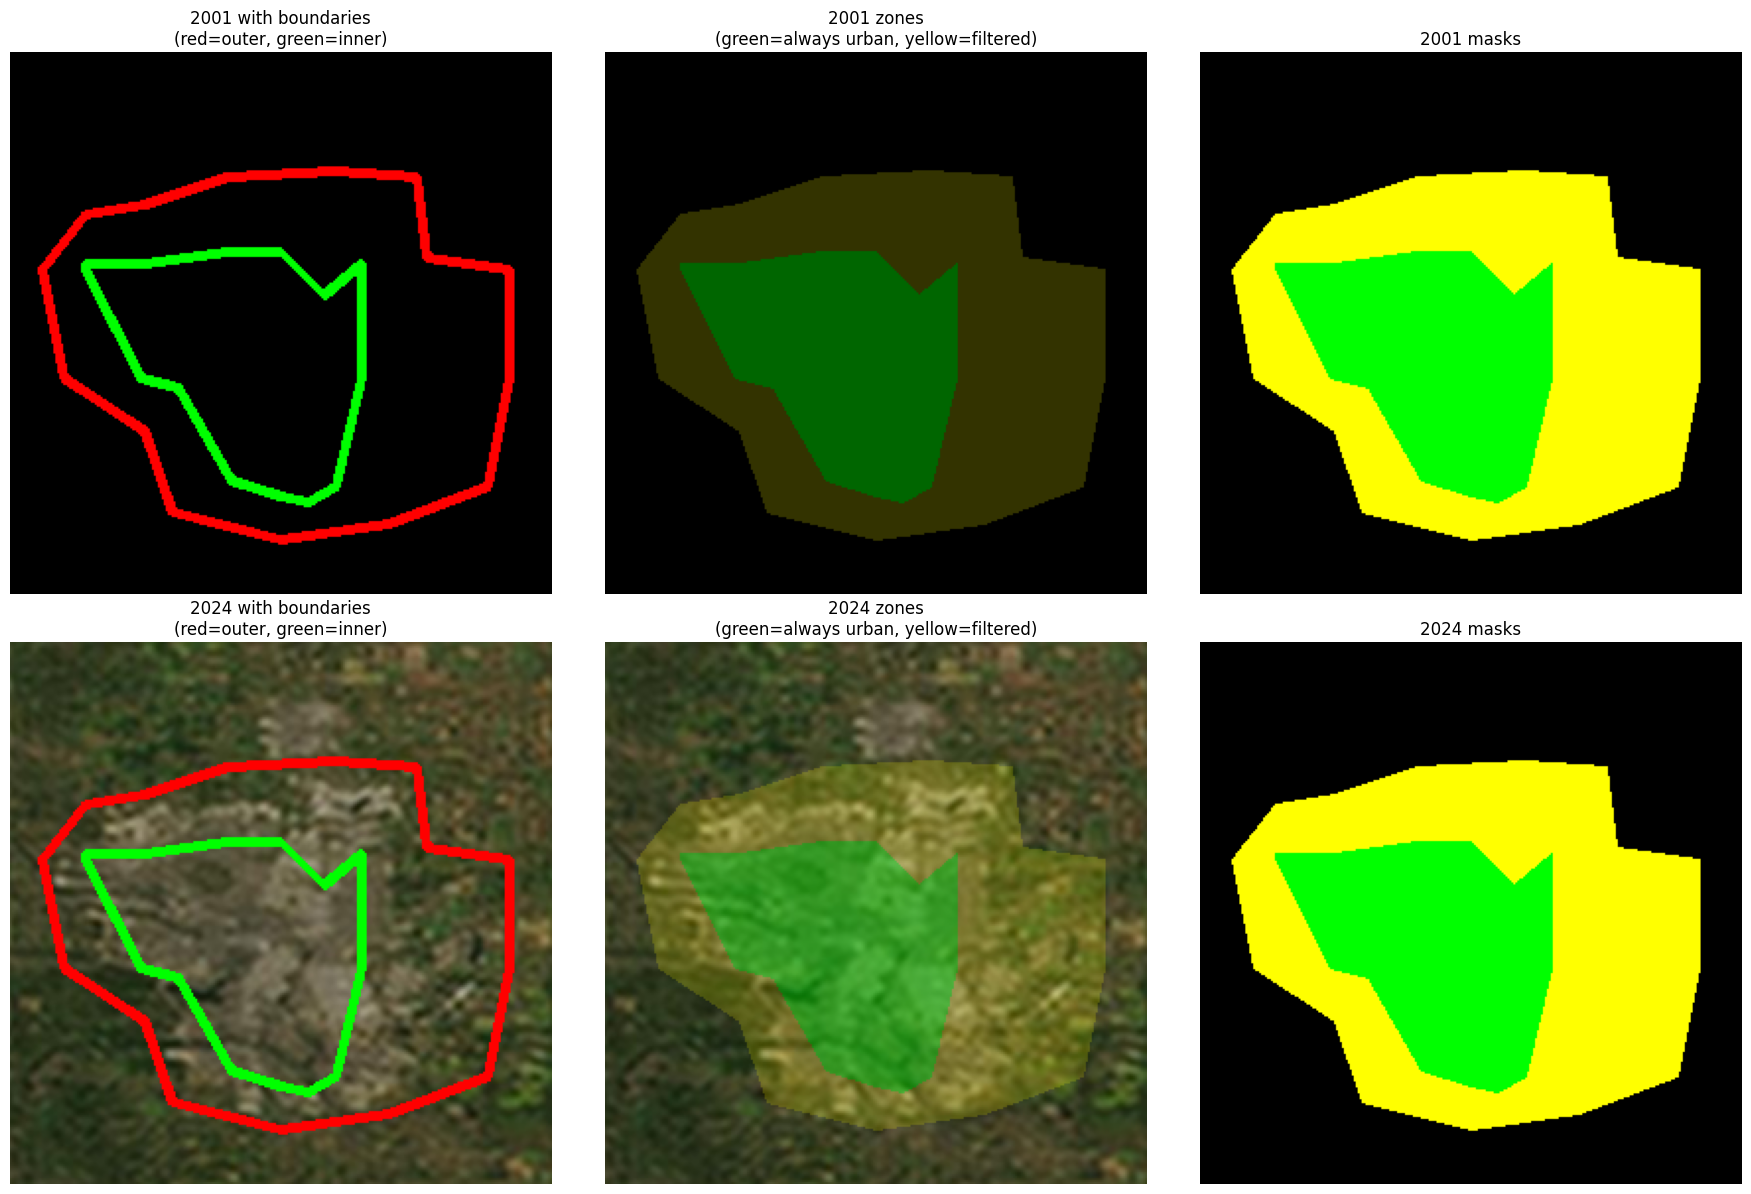

In [947]:
if PROCESSING_METHOD:
    # Optional: Check boundaries on 2001 and 2024 images

    # Get 2001 and 2024 images
    year_2001 = cleaned_df[cleaned_df['year'] == 2002].iloc[0]
    year_2024 = cleaned_df[cleaned_df['year'] == 2024].iloc[0]

    test_years = [(2001, year_2001), (2024, year_2024)]

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    for idx, (year, row) in enumerate(test_years):
        # Load image
        img = cv2.imread('./city_images/cleaned/basic_good_image_set/' + row['date']+'.jpg')
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        # Make boundaries
        outer_pts = np.array([[int(w*x), int(h*y)] for x, y in outer_boundary], dtype=np.int32)
        inner_pts = np.array([[int(w*x), int(h*y)] for x, y in inner_boundary], dtype=np.int32)
        
        outer = np.zeros((h, w), dtype=np.uint8)
        inner = np.zeros((h, w), dtype=np.uint8)
        cv2.fillPoly(outer, [outer_pts], 255)
        cv2.fillPoly(inner, [inner_pts], 255)
        
        # Image with boundary lines
        img_lines = img_rgb.copy()
        cv2.polylines(img_lines, [outer_pts], True, (255, 0, 0), 3)
        cv2.polylines(img_lines, [inner_pts], True, (0, 255, 0), 3)
        axes[idx][0].imshow(img_lines)
        axes[idx][0].set_title(f'{year} with boundaries\n(red=outer, green=inner)')
        axes[idx][0].axis('off')
        
        # Colored overlay
        overlay = img_rgb.copy()
        overlay[inner == 255] = overlay[inner == 255] * 0.6 + np.array([0, 255, 0]) * 0.4
        between = cv2.subtract(outer, inner)
        overlay[between == 255] = overlay[between == 255] * 0.8 + np.array([255, 255, 0]) * 0.2
        axes[idx][1].imshow(overlay)
        axes[idx][1].set_title(f'{year} zones\n(green=always urban, yellow=filtered)')
        axes[idx][1].axis('off')
        
        # Just masks
        masks = np.zeros((h, w, 3), dtype=np.uint8)
        masks[inner == 255] = [0, 255, 0]
        masks[between == 255] = [255, 255, 0]
        axes[idx][2].imshow(masks)
        axes[idx][2].set_title(f'{year} masks')
        axes[idx][2].axis('off')

    plt.tight_layout()
    plt.show()

In [948]:
# if PROCESSING_METHOD != True:
#     # Choose green thresholding values 
#     # lower_green = np.array([37, 40, 40]) # Hue, Saturation, Value
#     # upper_green = np.array([85, 255, 255]) 

#     lower_green = np.array([40, 40, 0]) # Hue, Saturation, Value
#     upper_green = np.array([85, 255, 255]) 

#     # Choose greyscale thresholding values 
#     lower_grey = 0  
#     upper_grey = 255

#     # Setup image list 
#     images_processed = [] 
#     # Setup loop for processing images 
#     for im_fn in cleaned_df['date']:
#         image = cv2.imread('./city_images/cleaned/basic_good_image_set/'+im_fn+'.jpg')
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
#         image_mask = cv2.inRange(image, lower_green, upper_green)
#         image_inverted_mask = cv2.bitwise_not(image_mask)
#         image = cv2.bitwise_and(image, image, mask=image_inverted_mask)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         ret, image_bitmask = cv2.threshold(image, lower_grey, upper_grey, cv2.THRESH_BINARY)
#         cv2.imwrite('./city_images/processed/basic_good_image_set/'+im_fn.split('.')[0]+'.bmp',image_bitmask)
#     # plt.imshow(image) # If you wnat to show an image, cv2.imshow() doesn't work well in notebooks, use plt instead 


In [949]:
if PROCESSING_METHOD != True:
    # Choose green thresholding values 
    # lower_green = np.array([37, 40, 40]) # Hue, Saturation, Value
    # upper_green = np.array([85, 255, 255]) 

    # Extract the Red channel (index 2)


    #grey = cv2.cvtColor(red_channel, cv2.COLOR_BGR2GRAY)
    

    # Setup image list 
    images_processed = [] 
    # Setup loop for processing images 
    for im_fn in cleaned_df['date']:
        image = cv2.imread('./city_images/cleaned/basic_good_image_set/'+im_fn+'.jpg')
        red_channel = image[:, :, 2]
        blue_channel = image[:, :, 0]
        ret, red_bitmask = cv2.threshold(red_channel, 60, 170, cv2.THRESH_BINARY)
        ret, blue_bitmask = cv2.threshold(blue_channel, 75, 150, cv2.THRESH_BINARY)
        result = cv2.bitwise_and(red_bitmask,blue_bitmask)
        cv2.imwrite('./city_images/processed/basic_good_image_set/'+im_fn.split('.')[0]+'.bmp',red_bitmask)
    # plt.imshow(image) # If you wnat to show an image, cv2.imshow() doesn't work well in notebooks, use plt instead 

# Image Analysis

In [950]:
# Determine distances of image manually 
distance_width = 42 # km - determined from calculator: https://www.nhc.noaa.gov/gccalc.shtml
distance_height = 67 # km - determined from calculator: " 

area_per_year = [] 

for im_fn in cleaned_df['date']:
    image = cv2.imread('./city_images/processed/basic_good_image_set/'+im_fn.split('.')[0]+'.bmp',cv2.IMREAD_GRAYSCALE)

    # Calculate sq km per pixel 
    pixel_width = 275 
    pixel_height = 275
    sqkmpp = (distance_width*distance_height)/(pixel_height*pixel_width)

    # Calculate area estimate 
    area_estimate = cv2.countNonZero(image)*sqkmpp
    area_per_year.append(area_estimate)

print(area_per_year)

[441.0491504132231, 610.9868429752066, 671.6762181818182, 1214.6061223140496, 888.4611966942149, 577.0886082644628, 548.8834909090909, 577.3490776859504, 773.2220826446281, 610.0938049586777, 615.824132231405, 647.1176727272727, 642.8013223140496, 1089.1342809917355, 611.1356826446281, 736.8307834710744, 631.2290380165289, 613.7403768595042, 760.0125619834711, 665.5365818181818, 1267.1465256198346, 1217.5084958677685, 1267.1465256198346, 1259.481282644628, 661.7039603305785, 684.5880595041323, 924.1827173553719, 786.8781223140496, 882.3959801652893, 774.0407008264463, 606.4844429752067, 1257.5463669421488, 1043.4032925619836, 732.2167537190082]


In [951]:
print(len(area_per_year))

34


In [952]:
years_manual = list(manual_df['year'])
manual_area = list(manual_df['Area Estimate'])
years_auto = cleaned_df['year']
per_error = [] 
for i in range(len(manual_area)):
    error = (area_per_year[i] - manual_area[i])/manual_area[i]*100
    per_error.append(error)


# Graph Visualization

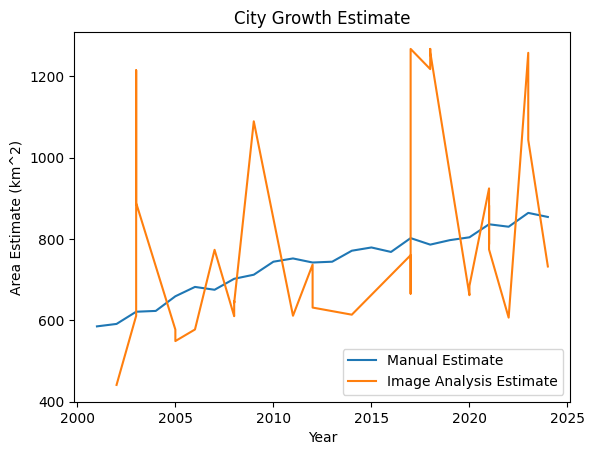

In [953]:
plt.plot(years_manual,manual_area,label='Manual Estimate')
plt.plot(years_auto,area_per_year,label='Image Analysis Estimate')
plt.xlabel('Year')
plt.ylabel('Area Estimate (km^2)')
plt.title('City Growth Estimate')
plt.legend()

Text(0.5, 1.0, 'Error in Estimate')

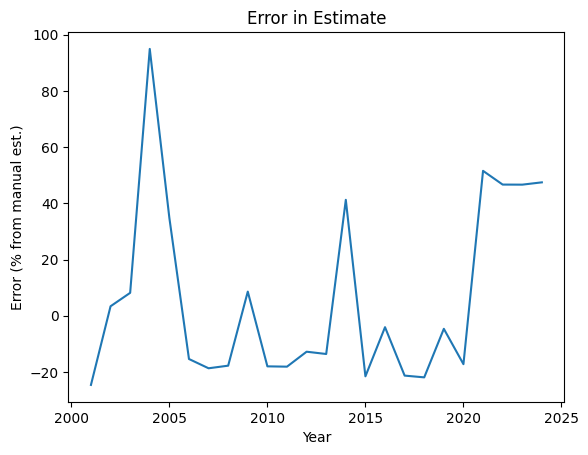

In [954]:
plt.plot(years,per_error)
plt.xlabel('Year')
plt.ylabel('Error (% from manual est.)')
plt.title('Error in Estimate')